In [3]:
import numpy as np
import pandas as pd
import os
from matplotlib.pyplot import *
import importlib
import subprocess

from ATARI.syndat.particle_pair import Particle_Pair
from ATARI.sammy_interface import sammy_interface, sammy_classes, sammy_functions

import ATARI.utils.io.hdf5 as h5io

from copy import copy
from ATARI.theory.resonance_statistics import make_res_par_avg


In [4]:
%matplotlib widget

In [5]:
case_file = '/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/fit_w_sammy/data.hdf5'  # if using hdf5

isample = 24
exp_pw, exp_cov = h5io.read_pw_exp(case_file, isample)
theo_par = h5io.read_par(case_file, isample, 'true')  #for fine grid theoretical
# import h5py
# with h5py.File(case_file) as f:
#     print(f.keys())

In [6]:
def plot_trans(exp_pw, T1):
    
    fig = figure()
    # plot(exp_pw.E, exp_pw.theo_trans, ms=1, color='g')
    # plot(sammyOUT.pw.E, sammyOUT.pw.theo_trans, 'r', alpha=0.2, lw=3)
    # plot(sammyOUT_bayes.pw.E, sammyOUT_bayes.pw.theo_trans_bayes, 'b-')
    plot(T1.E, T1.theo_trans, 'b')
    errorbar(exp_pw.E, exp_pw.exp, yerr=exp_pw.exp_unc, zorder=0, 
                                            fmt='.', color='k', linewidth=1, markersize=3, capsize=2, label='exp')
    ylim([-.1, 1])
    return fig


def plot_trans_cap(exp_pw, cap_pw, T1=None,C1=None):

    fig, axes = subplots(2,1, figsize=(8,6), sharex=True)
    axes[0].errorbar(exp_pw.E, exp_pw.exp, yerr=exp_pw.exp_unc, zorder=0, 
                                            fmt='.', color='k', linewidth=1, markersize=3, capsize=2, label='exp')
    
    axes[1].errorbar(cap_pw.E, cap_pw.exp, yerr=cap_pw.exp_unc, zorder=0, 
                                            fmt='.', color='k', linewidth=1, markersize=3, capsize=2, label='exp')
    
    if C1 is not None and T1 is not None:
        axes[0].plot(T1.E, T1.theo_trans, 'b')
        axes[1].plot(C1.E, C1.theo_xs, 'b')
    else:
        axes[0].plot(exp_pw.E, exp_pw.theo_trans, 'g')
        axes[1].plot(cap_pw.E, cap_pw.theo_xs, 'g')
        

    axes[0].set_ylabel("T")
    axes[1].set_yscale('log')
    axes[1].set_ylabel(r'$\sigma_{\gamma}$ (barns)')
    axes[1].set_ylim(bottom=5e-4)

    # legend()
    fig.supxlabel('Energy (eV)')
    fig.tight_layout()
    return fig


In [7]:
Gg_DOF = 10
spin_groups = [ (3.0,1,0) ]
res_par_avg = make_res_par_avg(D_avg = 8.79, 
                            Gn_avg= 0.658, #0.658, 
                            n_dof = 1, 
                            Gg_avg = 64.0, 
                            g_dof = Gg_DOF, 
                            print = False)

ac = 0.81271; M = 180.948030; m = 1; I = 3.5; i = 0.5; l_max = 1 
average_parameters = {'3.0':res_par_avg}
Ta_pair = Particle_Pair( ac, M, m, I, i, l_max,
                                input_options={},
                                spin_groups=spin_groups,
                                average_parameters=average_parameters )   

In [8]:
# columns=['E', 'Gg', 'Gn1', 'Gn2', 'Gn3', 'varyE', 'varyGg', 'varyGn1', 'varyGn2', 'varyGn3', 'J_ID']
# importlib.reload(sammy_functions) 
# sammy_functions.write_sampar(initial_reslad, Ta_pair, 0.1, "./test")

sammyRTO = sammy_classes.SammyRunTimeOptions(
    path_to_SAMMY_exe = '/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy',
    model = 'XCT',
    reaction = 'transmission',
    solve_bayes = False,
    inptemplate = "allexptot_1sg.inp",
    inpname = "sammy.inp",
    energy_window = None,
    sammy_runDIR = 'SAMMY_runDIR',
    keep_runDIR = True,
    shell = 'zsh'
    )

sammyINP = sammy_classes.SammyInputData(
    particle_pair = Ta_pair,
    resonance_ladder = theo_par,
    experimental_data=exp_pw,
    temp = 304.5,
    FP=35.185,
    frac_res_FP=0.049600,
    target_thickness=0.067166,
    initial_parameter_uncertainty=1.0)

sammyOUT = sammy_functions.run_sammy(sammyINP, sammyRTO)

In [9]:
## capture data if using
sammyRTO_cap = copy(sammyRTO)
sammyRTO_cap.inptemplate = 'allexpcap_1sg.inp'
sammyRTO_cap.reaction = 'capture'

sammyINP.resonance_ladder = theo_par
out_cap = sammy_functions.run_sammy(sammyINP, sammyRTO_cap)

unc_scale = 0.05
cap_pw = out_cap.pw
cap_pw["exp"] = abs(np.random.default_rng().normal(cap_pw["theo_xs"], np.sqrt(cap_pw["theo_xs"])*unc_scale ))
cap_pw["exp_unc"] = np.sqrt(cap_pw["exp"])*unc_scale

# fig = plot_trans_cap(exp_pw, cap_pw, T1=None, C1=None)

In [10]:

# ifinal = int(result.splitlines()[-1]) -1
ifinal=24
iE = 30

P1 = sammy_functions.readpar(os.path.join(f"/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/fit_w_sammy/SAMMY_runDIR_Gnavg/sample_{isample}_iE{iE}_step1",f"results/step{ifinal}.par"))
T1 = sammy_functions.readlst(os.path.join(f"/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/fit_w_sammy/SAMMY_runDIR_Gnavg/sample_{isample}_iE{iE}_step1",f"results/trans1_step{ifinal}.lst"))
C1 = sammy_functions.readlst(os.path.join(f"/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/fit_w_sammy/SAMMY_runDIR_Gnavg/sample_{isample}_iE{iE}_step1",f"results/cap1_step{ifinal}.lst"))


In [11]:
T1

,E,exp_xs,exp_xs_unc,theo_xs,theo_xs_bayes,exp_trans,exp_trans_unc,theo_trans,theo_trans_bayes
0,75.029778,5.274940,0.792850,6.188670,0.0,0.701652,0.037367,0.659899,NaN
1,75.082129,3.641843,0.767405,6.024219,0.0,0.783000,0.040361,0.667228,NaN
2,75.134535,3.932236,0.790955,5.674139,0.0,0.767875,0.040796,0.683103,NaN
3,75.186995,4.688530,0.783564,5.219576,0.0,0.729841,0.038413,0.704281,NaN
4,75.239510,4.577873,0.769805,4.765075,0.0,0.735286,0.038020,0.726112,NaN
...,...,...,...,...,...,...,...,...,...
642,124.551153,4.225105,0.716938,3.796240,0.0,0.752917,0.036258,0.774933,NaN
643,124.663138,4.425444,0.710718,3.982404,0.0,0.742853,0.035463,0.765304,NaN
644,124.775274,5.130680,0.723951,4.302894,0.0,0.708484,0.034452,0.749006,NaN
645,124.887561,4.390054,0.708651,4.635205,0.0,0.744621,0.035444,0.732473,NaN


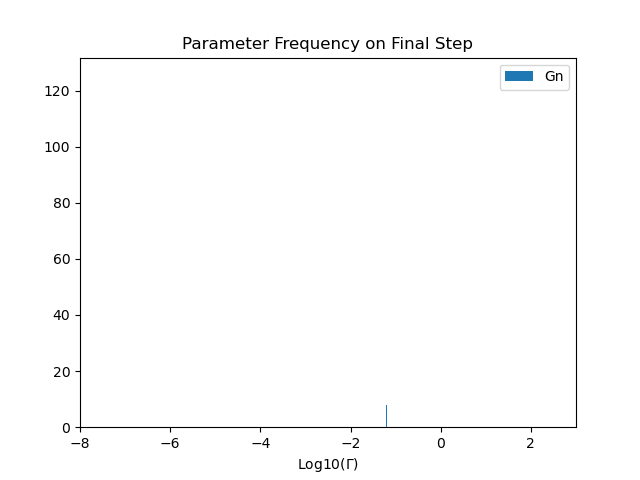

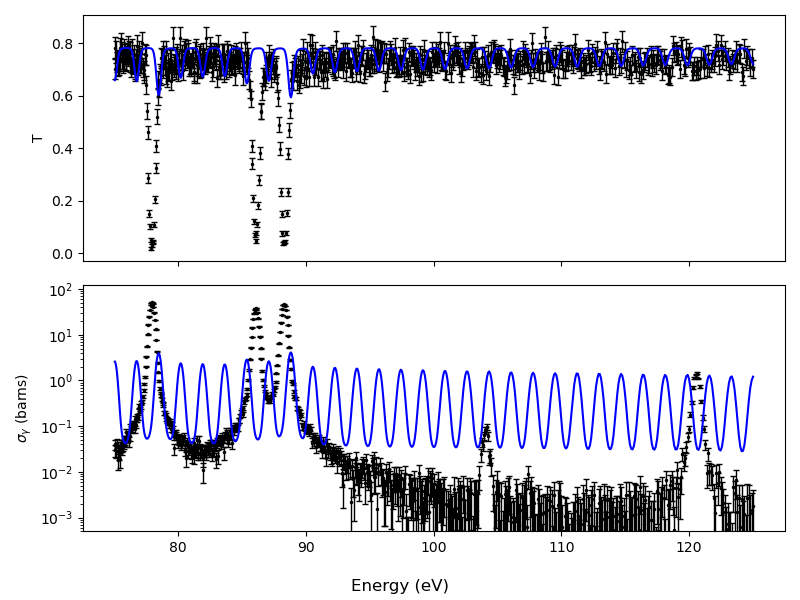

In [12]:
figure()
bins = hist(np.log10(P1.Gn1), bins=75, density=True, label="Gn")
# bins = hist(np.log10(P1.Gg), bins=75, density=True, alpha=0.75, label="Gg")
xlabel(r'Log10($\Gamma$)'); title("Parameter Frequency on Final Step")
legend()
xlim([-8, 3])
# savefig(f"/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/fit_w_sammy/case_2a.png")

fig = plot_trans_cap(exp_pw, cap_pw, T1=T1, C1=C1)
# fig = plot_trans(exp_pw, T1)

In [14]:

# ifinal = int(result.splitlines()[-1]) -1
ifinal=2

P2 = sammy_functions.readpar(os.path.join(f"/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/fit_w_sammy/SAMMY_runDIRs/sample_{isample}_step2",f"results/step{ifinal}.par"))
T2 = sammy_functions.readlst(os.path.join(f"/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/fit_w_sammy/SAMMY_runDIRs/sample_{isample}_step2",f"results/trans1_step{ifinal}.lst"))
C2 = sammy_functions.readlst(os.path.join(f"/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/fit_w_sammy/SAMMY_runDIRs/sample_{isample}_step2",f"results/cap1_step{ifinal}.lst"))


fig = plot_trans_cap(exp_pw, cap_pw, T1=T2, C1=C2)


FileNotFoundError: [Errno 2] No such file or directory: '/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/fit_w_sammy/SAMMY_runs/sample_0_step2/results/step2.par'

In [108]:
len(P2)



43

In [ ]:
import imageio


def make_fitgif(isample, iE):

    with open(f"/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/fit_w_sammy/ifinal_nE{iE}.txt", 'r') as f:
        lines = f.readlines()
    for line in lines:
        if line.startswith(f"{isample} "):
            ifinals = line.split()
    
    for istep in [1,2,3,4]:
        folder = f"/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/fit_w_sammy/SAMMY_runDIRs/sample_{isample}_iE{iE}_step{istep}"
        for i in range(1,int(ifinals[istep])):
            
            C1 = sammy_functions.readlst(os.path.join(folder,f"results/cap1_step{i}.lst"))
            T1 = sammy_functions.readlst(os.path.join(folder,f"results/trans1_step{i}.lst"))
            fig = plot_trans_cap(exp_pw, cap_pw, T1=T1, C1=C1)
            fig.suptitle(f"Step: {istep}")

            fig.savefig(f"/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/fit_w_sammy/SAMMY_runDIRs/figures/sample{isample}_iE{iE}_step{istep}_{i}.png")
            close()
        
    images = []
    for istep in [1,2,3,4]:
        for i in range(1,int(ifinals[istep])): #range(start_job,end_job):
            images.append(imageio.imread(f"/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/fit_w_sammy/SAMMY_runDIRs/figures/sample{isample}_iE{iE}_step{istep}_{i}.png"))
    imageio.mimsave(f"/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/fit_w_sammy/sample{isample}_iE{iE}.gif", images)

In [ ]:
make_fitgif(0, 40)


/var/folders/s9/xdv2y9hs0y7g3zzscy35rz4c0000gn/T/ipykernel_35036/1029206176.py:26: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f"/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/fit_w_sammy/SAMMY_runDIRs/figures/sample{isample}_iE{iE}_step{istep}_{i}.png"))


In [19]:
# os.system(os.path.join(sammyRTO.sammy_runDIR, 'run.zsh'))
